In [34]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import pandas as pd

In [20]:
tp_details0 = torch.load('results/EVAL:tldr:sft_temperature-policy_judge:gpt-4o_n:100_bs:8_model:vwxyzjn/EleutherAI_pythia-1b-deduped__sft__tldr/sft__44413__1708611267_ckpt:model_epoch0_step999.pt_seed:510/temperature_policy_logs.pt')
tp_details1 = torch.load('results/EVAL:tldr:sft_temperature-policy_judge:gpt-4o_n:100_bs:8_model:vwxyzjn/EleutherAI_pythia-1b-deduped__sft__tldr/sft__44413__1708611267_ckpt:model_epoch30_step30999.pt_seed:510/temperature_policy_logs.pt')
print(tp_details0.keys())

def add_metrics(tp_details):
    temps = torch.cat(tp_details['temps'], dim=0).flatten()
    tp_details['processed_temps'] = temps
    input_scores = torch.cat(tp_details['input_scores'], dim=0)
    input_scores = torch.nn.functional.softmax(input_scores, dim=1)
    tp_details['softmax_scores'] = input_scores
    tp_details['max_token_scores'] = torch.max(input_scores, dim=1)[0]
    entropies = -torch.sum(input_scores * torch.log(input_scores), axis=1) / np.log(temps.shape[0])
    tp_details['entropies'] = entropies 
    tp_details['sum_squares'] = torch.sum(input_scores * input_scores, dim=1)
    tp_details['joined_embs'] = torch.cat(tp_details['next_token_embs'], dim=0)
    

add_metrics(tp_details0)
add_metrics(tp_details1)

dict_keys(['temps', 'input_scores', 'next_token_embs'])


In [ ]:
# Correlation between entropies and temperatures
for feature in ['max_token_scores', 'entropies', 'sum_squares']:
    feature_vec = tp_details1[feature]
    temp_vec = tp_details1['processed_temps']
    print(feature_vec.shape)
    print(temp_vec.shape)
    corr = scipy.stats.pearsonr(feature_vec, temp_vec)
    print(feature)
    print(corr)
    print('\n\n===============\n\n')

<Axes: xlabel='correlation', ylabel='Count'>

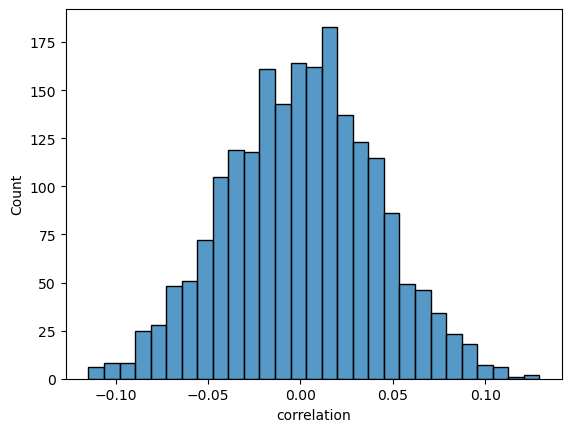

In [37]:
corrs = []
temp_vec = tp_details1['processed_temps']
for i in range(2048):
    feature_embs = tp_details1['joined_embs'][:,i]
    corr = scipy.stats.pearsonr(feature_embs, temp_vec)
    corr = corr[0]
    if corr > 0.3 or corr < -0.3:
        print(corr)
    corrs.append(corr)

corrs = pd.DataFrame({'correlation': corrs})
sns.histplot(data=corrs, x="correlation")